## Computer Vision
## Part A

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the file containing images with details of bounding boxes

In [2]:
import numpy as np
data = np.load('/content/drive/My Drive/projectCV/images.npy', allow_pickle=True)

### Checking one sample from the loaded file

In [3]:
data[10][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

### Setting image dimensions

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Creating features and labels

In [5]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Splitting the data into training and testing
- 400 images in training
- 9 images in testing data

Training data

In [6]:
X_train = X[:400]
y_train = masks[:400]

Testing data

In [7]:
X_test = X[400:]
y_test = masks[400:]

### Printing a sample training image, image array and its mask

Image array: [[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.9

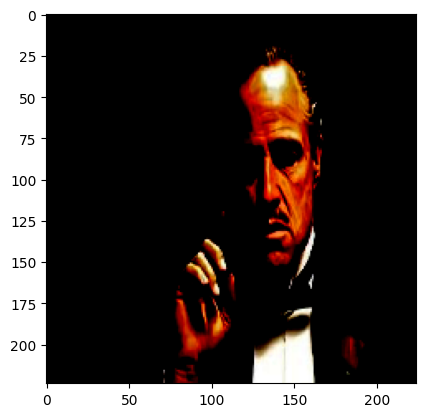

In [8]:
import matplotlib.pyplot as plt

n = 10
print("Image array:", X_train[n])
plt.imshow(X_train[n])

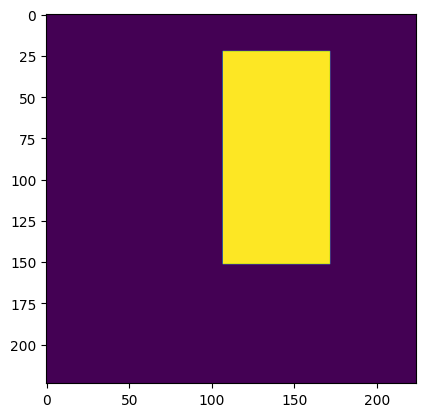

In [9]:
plt.imshow(masks[n])

## Create the model
- Addding MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Adding UNET architecture layers

In [10]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

### Calling the create_model function

In [11]:
model = create_model()

17225924/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


### Printing model summary

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

### Defining dice coefficient function
- Creating a function to calculate dice coefficient


In [13]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

### Defining loss function

In [14]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compiling the model using below parameters
  - loss: using the loss function defined above
  - optimizer: using Adam optimizer
  - metrics: using dice_coefficient function defined above

In [15]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### Defining callbacks
- Using ModelCheckpoint
- Using EarlyStopping
- Using ReduceLROnPlateau

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fitting the model using below parameters
  - epochs: 10
  - batch_size: 1
  - callbacks: using the callbacks defined above

In [17]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
399/400 [============================>.] - ETA: 0s - loss: 1.2429 - dice_coefficient: 0.5073
Epoch 1: loss improved from inf to 1.24108, saving model to model-1.24.h5
400/400 [==============================] - 38s 44ms/step - loss: 1.2411 - dice_coefficient: 0.5077 - lr: 0.0010
Epoch 2/10
399/400 [============================>.] - ETA: 0s - loss: 0.8566 - dice_coefficient: 0.6017
Epoch 2: loss improved from 1.24108 to 0.85538, saving model to model-0.86.h5
400/400 [==============================] - 17s 41ms/step - loss: 0.8554 - dice_coefficient: 0.6023 - lr: 0.0010
Epoch 3/10
399/400 [============================>.] - ETA: 0s - loss: 0.7219 - dice_coefficient: 0.6489
Epoch 3: loss improved from 0.85538 to 0.72192, saving model to model-0.72.h5
400/400 [==============================] - 17s 41ms/step - loss: 0.7219 - dice_coefficient: 0.6488 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.6545 - dice_coefficient: 0.6760
Epoch 4: loss impr

### Getting the predicted mask for a test image

Showing the test image

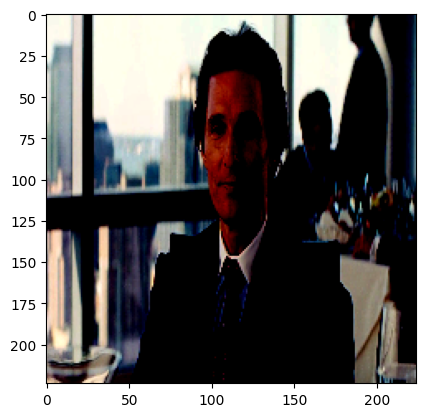

In [18]:
m = 3
plt.imshow(X_test[m])

Show original mask for test image

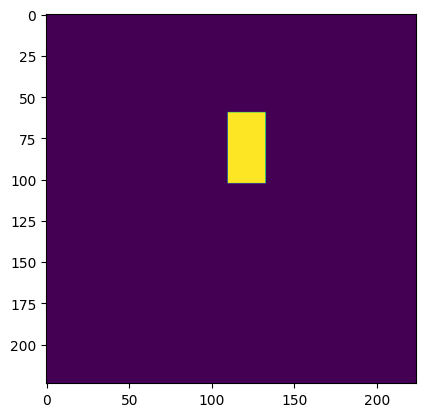

In [19]:
plt.imshow(masks[m])

Predicting the mask on the test image

In [20]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))

1/1 [==============================] - 0s 484ms/step


### Imposing the mask on the test image
- In imshow using the alpha parameter and setting it to 0.9 (i.e. > 0.5)

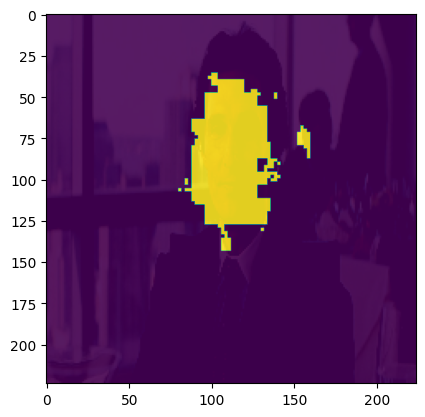

In [21]:
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=0.9)

## Part B

In [23]:
import os
os.chdir('/content/drive/My Drive/projectCV')

import cv2
import os
import pandas as pd
from zipfile import ZipFile

# Step 1: Unzip the ZIP file
zip_file_path = 'training_images-20211126T092819Z-001.zip'
unzip_folder = 'unzipped_training_images'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder)

# Step 2: Loop through images and detect faces
folder_path = unzip_folder
image_files = os.listdir(folder_path)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

face_data = []

for file_name in image_files:
     # Read image
    image_path = os.path.join(folder_path, file_name)
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Unable to read image '{file_name}'. Skipping...")
        continue

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Step 3: Extract metadata of faces
    for (x,y,w,h) in faces:
        face_data.append({
            'Image': file_name,
            'Face_X': x,
            'Face_Y': y,
            'Face_Width': w,
            'Face_Height': h
        })

# Step 4: Save output DataFrame to CSV
df = pd.DataFrame(face_data)
df.to_csv('faces_metadata.csv', index=False)

print("Metadata saved to 'faces_metadata.csv'")


Error: Unable to read image 'training_images'. Skipping...
Metadata saved to 'faces_metadata.csv'


## Part C

### Extracting the zip file

In [24]:
from zipfile import ZipFile
with ZipFile('PINS.zip', 'r') as zip:
  zip.extractall()

### Function to load images
- Defining a function to load the images from the extracted folder and mapping each image with person id


In [25]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

### Defining function to load image
- Defining a function to load image from the metadata

In [26]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Loading a sample image
- Loading one image using the function "load_image"

array([[[67, 56, 50],
        [62, 51, 45],
        [56, 45, 39],
        ...,
        [22, 19, 12],
        [22, 19, 12],
        [23, 18, 12]],

       [[65, 54, 48],
        [64, 53, 47],
        [56, 45, 39],
        ...,
        [22, 19, 12],
        [22, 19, 12],
        [23, 18, 12]],

       [[61, 50, 46],
        [59, 48, 44],
        [47, 36, 30],
        ...,
        [23, 18, 12],
        [23, 18, 12],
        [23, 18, 12]],

       ...,

       [[60, 40, 41],
        [60, 40, 41],
        [56, 36, 37],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]],

       [[60, 40, 41],
        [60, 40, 41],
        [57, 37, 38],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]],

       [[61, 41, 42],
        [60, 40, 41],
        [57, 37, 38],
        ...,
        [30, 21, 16],
        [31, 22, 17],
        [31, 22, 17]]], dtype=uint8)
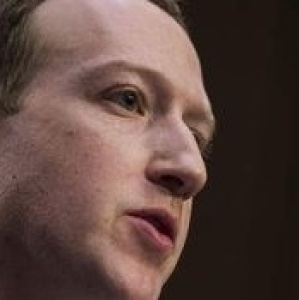

In [27]:
# Loading an image
load_image(metadata[0].image_path())

### Using VGG Face model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Loading the the model defined above
- Then loading the given weight file

In [29]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

### Get vgg_face_descriptor

In [30]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generating embeddings for each image in the dataset


In [31]:
# Getting embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtaining embedding vector for an image
# Getting the embedding vector for the above image using vgg_face_descriptor model and printing the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 2s 2s/step
(2622,)


### Generating embeddings for all images
- Writing code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and storing in a list with name `embeddings`

- If there is any error in reading any image in the dataset, we will fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [32]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


### Function to calculate distance between given 2 pairs of images.


In [33]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plotting images and getting distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

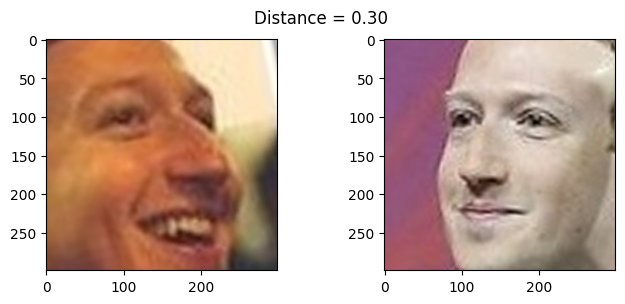

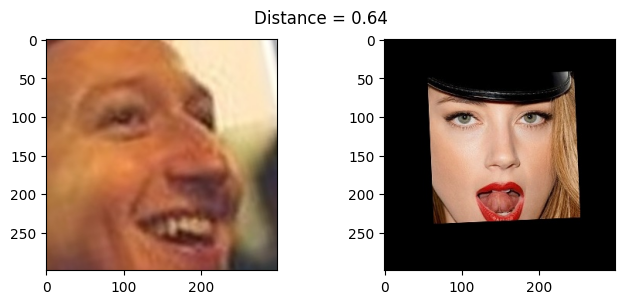

In [34]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

### Creating train and test sets

In [35]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

### Encoding the Labels

In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### Standardizing the feature values

In [37]:
# Standarizing features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Reducing dimensions using PCA

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Building a Classifier

In [39]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9598997493734336

### Test results
- Taking random image from test set and plot the image
- Reporting to which person the image belongs to

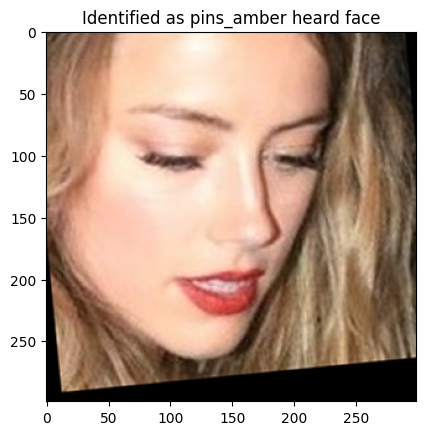

In [40]:
import warnings
# Suppressing LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = clf.predict([X_test[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

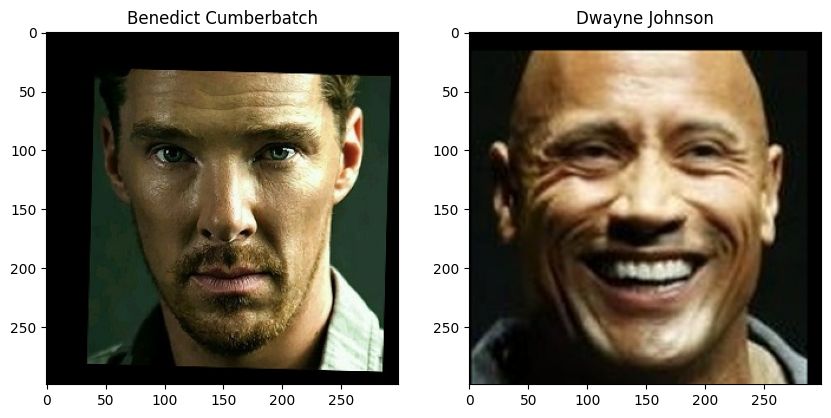

In [44]:
# Import and display the the test images

# Load the test images
image1 = load_image('Benedict Cumberbatch9.jpg')
image2 = load_image('Dwayne Johnson4.jpg')

# Display the test images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Benedict Cumberbatch')
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Dwayne Johnson')
plt.show()
